# Using PauliStrings.jl to simulate the discrete time XXZ model

## Discrete time XXZ model in a given geometry
Let's say we have a geometry defined by some graph $g$. At each vertex of $g$ we have a spin-1/2 degree of freedom, and each edge represents a coupling between local degrees of freedom. The discrete time models on this graph that we will be interested here will be defined by a collection of 2-site unitaries $u_e$ corresponding to each edge $e$, and a partitioning of the edges of $g$ into layers, each of which contains at most a single edge containing any given vertex. This corresponds to an edge colouring of $g$. 

Let $L_1, L_2, ..., L_k$ be the layers corresponding to a given colouring of $g$. The unitary $\mathcal{U}$ corresponding to a single `timestep' of this circuit is then:
\begin{equation}
    \mathcal{U} = \left(\prod_{e\in L_k}u_e\right)...\left(\prod_{e\in L_2}u_e\right)\left(\prod_{e\in L_1}u_e\right)
\end{equation}

For the spatially homogenous XXZ model, we have $$u_e = \exp\left(-iJ(X\otimes X + Y\otimes Y) -iJ\Delta Z\otimes Z\right),$$ where $J$ is the overall coupling strength, and $\Delta$ is the spin anisotropy.

In this code, we will study the two point spin correlators at infinite temperature: $$C_{jk}(t) = \text{Tr}\left(Z_j(0) Z_k(t)\right)/2^N = \text{Tr}\left(Z_j (\mathcal{U}^\dagger)^t Z_k \mathcal{U}^t\right)/2^N = \text{Tr}\left(\mathcal{U}^t Z_j (\mathcal{U}^\dagger)^t Z_k\right)/2^N = \text{Tr}\left(Z_k(0) Z_j(-t)\right)/2^N.$$ (Note that if we evolve $Z_j$ backwards in time, we only need to evolve a single operator to calculate the spread of spin correlations from an initial excitation at site $j$).

## PauliStrings update procedure
We will procede in the following way:
- Initialize $Z_j$
- Use Pauli Propagation methods to update this operator over $t$ timesteps
- Extract Pauli coefficients corresponding to each $Z_k$ to calculate $C_{jk}(t)$

# Pauli Propagation
Let's say we have some observable $\mathcal{O}$ and we want to update it via $\mathcal{O} \rightarrow u^\dagger \mathcal{O} u$, where $u$ is generated by a single Pauli string, ie, $u = \exp\left(-iP\theta / 2\right)$. Then if we expand $\mathcal{O}$ in the Pauli basis, i.e, $$\mathcal{O} = \sum_\sigma c_ \sigma\sigma,$$ where each $\sigma$ is a Pauli string, then we can update each $\sigma$ in the expansion of $\mathcal{O}$ in the following way:
\begin{equation}
    u^{\dagger}\sigma u = \begin{cases}
        \cos(\theta)\sigma  + i\sin(\theta)P\sigma & \text{if }  \{P, \sigma\} = 0
        \\ \sigma  \text{ otherwise}
    \end{cases}
\end{equation}
Now let's suppose $\mathcal{O}_j$ is our observable propagated after $j$ gates. We can write the following update rules:
\begin{align*}
    \mathcal{O}_j  & = \sum_{\sigma} c_{\sigma, j}\sigma
    \\
    c_{\sigma, j+1} &= \cos^{\xi_{\sigma, j+1}}(\theta_{j+1}
) + i\xi_{\sigma, j+1}\sin(\theta_{j+1}) c_{P_{j+1}\sigma, j}
\\
\xi_{\sigma, k} & = \mathbf{1}_{\{\{\sigma, P_k\} = 0\}},
\end{align*}
where $c_{\sigma, 0}$ are set by the choice of $\mathcal{O}$. We also note that for $N$ qubits, there are $4^N$ Pauli strings. Thus for the simulation to be tractable for most circuits, we must control the number of nonzero $c_{\sigma, j}$ being propagated forwards at any given update step. In particular, we opt to truncate $\vec{c}_j$ solely based on a maximum length of nonzero entries. Empirically this seems to give much better results than other methods.

Also, if we want to calculate $\text{Tr}(\mathcal{O}_j Q)$ where $Q$ is some Pauli string, we need only extract the coefficient $c_{Q, j}$. This means that to calculate our correlators $C_{jk}(t)$ above, we just need to propagate $Z_j$ and then pick out the relevant coefficients.

## XXZ interaction in this picture

The two site XXZ interaction is given by $u = \exp\left(-iJ(X\otimes X + Y\otimes Y) -iJ\Delta Z\otimes Z\right)$. Luckily, $$[X\otimes X, Y\otimes Y] =  [Y\otimes Y, Z\otimes Z] = [Z\otimes Z, X\otimes X] = 0,$$ and so we can exactly break $u$ into a product of $3$ single Pauli rotations:
$$
u = \exp(-i\Delta J Z\otimes Z) \exp(-iJ Y\otimes Y) \exp(-iJ X\otimes X).
$$

This means our circuit can exactly be written as a product of $3$ Pauli rotations per interaction. In general, a two qubit unitary $V$ can be written in the following form (up to an unimportant phase):
$$
V = (v_1\otimes v_2) e^{-iJ_x X\otimes X}e^{-iJ_y Y\otimes Y}e^{-iJ_z Z\otimes Z} (v_3\otimes v_4),
$$
where $v_1,...,v_4$ are single qubit unitaries. Thus, $15$ rotations generated by a single Pauli string each may be required to exactly represent $V$.

# The Code
Import libraries. ITensorNetworks etc added here to compare Pauli propagation to belief propagation later.

In [3]:
using Pkg
Pkg.activate(".")
Pkg.add("PauliStrings");
Pkg.add("NamedGraphs");
Pkg.add("Graphs");
Pkg.add("ITensorNetworks");
Pkg.add("Plots")
Pkg.add("TimerOutputs")

using TimerOutputs
using PauliStrings
const ps = PauliStrings
using NamedGraphs
using Graphs
const NG = NamedGraphs
const G = Graphs
using NamedGraphs.NamedGraphGenerators: named_grid
Pkg.add("SimpleGraphAlgorithms")
using SimpleGraphAlgorithms: edge_color
using Plots
using Random

Pkg.status("PauliStrings")

  Activating project at `~/Dropbox/Ortisei`
   Resolving package versions...
  No Changes to `~/Dropbox/Ortisei/Project.toml`
  No Changes to `~/Dropbox/Ortisei/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/Ortisei/Project.toml`
  No Changes to `~/Dropbox/Ortisei/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/Ortisei/Project.toml`
  No Changes to `~/Dropbox/Ortisei/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/Ortisei/Project.toml`
  No Changes to `~/Dropbox/Ortisei/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/Ortisei/Project.toml`
  No Changes to `~/Dropbox/Ortisei/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/Ortisei/Project.toml`
  No Changes to `~/Dropbox/Ortisei/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/Ortisei/Project.toml`
  No Changes to `~/Dropbox/Ortisei/Manifest.toml`


Status `~/Dropbox/Ortisei/Project.toml`
  [f07625cc] PauliStrings v1.6.0


### Function that updates an observable via the anticommutator check from earlier:

In [4]:
function apply_gate(O, P, θ; M=2^10, alt_trim=false, keep=Operator(0))
    @assert length(P.strings) == 1 "Gate must be generated by a single pauli generator"
    d = ps.emptydict(O)
    P = P.strings[1]
    for i in 1:length(O.strings)
        O_i, c_i = O.strings[i], O.coeffs[i]
        anticom = ps.anticommutator(O_i, P)

        if anticom[2] == 0
            c = c_i * cos(θ)
            ps.setwith!(+, d, O_i, c)
            p_n, k_n = ps.prod(P, O_i)

            c_n = sin(θ) * c_i * k_n * im
            ps.setwith!(+, d, p_n, c_n)
        
        else
            ps.setwith!(+, d, O_i, c_i)
        end

    end
    O_new = Operator(collect(keys(d)), collect(values(d)))
    O_new = ps.trim(O_new, M; keep=keep, keepnorm=false)
    return O_new
end;

function apply_gate_list(O, gate_list, angle_list; M=2^10, noise=0, keep=Operator(0))
    for i in 1:length(gate_list)
        O = apply_gate(O, gate_list[i], angle_list[i], M=M, keep=keep)
    end
    O = ps.add_noise(O, noise)
    return O
end;

### Function that builds propagators for a single timestep of the XXZ circuit given system size, interaction params, and the Trotter layers:

In [5]:
# Function that will help us with arbitrary graph labellings later
function vertex_to_int(graph, vertex)
    return findfirst(x -> x ==(vertex), collect(vertices(graph)))
end

function xxz_step(N, J_dict, Δ, trotter_layers)

    gate_list = []
    angle_list = []

    for layer in trotter_layers
        for edge in layer

            q1, q2 = vertex_to_int(graph, src(edge)), vertex_to_int(graph, dst(edge))

            xx_angle = 2 * J_dict[edge]
            zz_angle = Δ * xx_angle

            for (pauli, angle) in zip(("X", "Y", "Z"), (xx_angle, xx_angle, zz_angle))
                generator = ps.Operator(N)
                generator += pauli, q1, pauli, q2
                push!(gate_list, generator)
                push!(angle_list, angle)
            end

        end
    end

    return gate_list, angle_list
end;

### Now we perform the propagation and pick out the relevant coefficients:

In [6]:
# Generate all local Z ops
function single_Z_operators(N)
    ops = Operator[]
    for i in 1:N
        O = Operator(N)
        O += "Z", i
        push!(ops, O)
    end
    return ops
end


# Calculate two-point correlators over a given number of timesteps
function two_point_correlators(N, J_dict, Δ, trotter_layers, num_steps, O; M=2^10, noise=0, keep=Operator(0))
    O0 = deepcopy(O)
    correlators = []
    gate_list, angle_list = xxz_step(N, J_dict, Δ, trotter_layers)
    for t in 1:num_steps
        println("Time Step $t")
        correlators_t = [ps.trace_product(O, local_Z)/big(2)^N for local_Z in all_local_Z]
        push!(correlators, correlators_t)
        O = apply_gate_list(O, gate_list, angle_list; M=M, noise=noise, keep=keep)
    end
    return real.(correlators)
end;

### Define our model geometry and interaction parameters

In [7]:
# Let's put the model on a square lattice
nx, ny = 10, 10

N = nx * ny
graph = named_grid((nx, ny))
trotter_layers = edge_color(graph, 4)
#int_to_vertex = Dict(i => v for (v, i) in vertex_to_int)

# Interaction params
Δ = 1.0;
J_dict = Dict(e => 1.0 for e in edges(graph));

# Number of time steps
num_steps = 20

# Let's initialise the observable on the center site
initial_site = 1

# Which operators to measure
all_local_Z = single_Z_operators(N)

# Keep coefficients corresponding to the collection of local Z at each step to make sure they don't get trimmed off
keep_op = ps.Operator(N)
for local_Z in all_local_Z
    keep_op += local_Z
end

# Cutoff params
Ms = [2^12, 2^14, 2^16];



### Now we run the simulation

In [ ]:
results_pauli = Dict()
times_pauli = Dict()

for M in Ms
    println("Running PauliStrings with M = $M")
    to = TimerOutput()
    O = ps.Operator(N)
    O += "Z", initial_site
    runtime = @elapsed begin
        @timeit to "Pauli evolution" begin
            results = two_point_correlators(N, J_dict, Δ, trotter_layers, num_steps, O; M=M, noise=0, keep=keep_op);
        end
    end
    show(to)
    results_pauli[M] = results
    times_pauli[M] = runtime
end


### Plot the results

In [ ]:
p = Plots.plot()

for M in Ms
    array_to_plot = [results_pauli[M][t][initial_site] for t in 1:num_steps]
    plot!(1:num_steps, abs.(array_to_plot),
        label="PauliStrings M=$M (time=$(round(times_pauli[M],digits=2))s)", lw=2, yaxis=:log, xaxis=:log)
end



t=1:num_steps
limit_array = [results_pauli[2^12][t][initial_site] for t in 1:num_steps]
power = round(-2/3, digits=3)
for offset in -100:100
    if offset == 0
        plot!(t, 10.0^(offset/6) .* float.(t) .^ power, color=:gray, alpha=0.5, lw=1, label="t^$power")
    end
    plot!(t, 10.0^(offset/6) .* float.(t) .^ power, color=:gray, alpha=0.5, lw=1, label="")
    continue
end
xlims!(minimum(t), maximum(t))
ylims!(minimum(abs.(limit_array)), maximum(abs.(limit_array)))

xlabel!("time step t")
ylabel!("C(t) = Tr[Z_$initial_site(t)Z_$initial_site] / 2^N")
title!("Square Lattice XXZ Circuit (N=$N, Δ=$Δ)")
plot!(grid=false)
plot!(legend=:topright)

In [8]:
function u1_coords_sample()
    θ1, θ2, θ3, θ4, Jx, Jz = rand(Uniform(-π, π), 6)
    return θ1, θ2, θ3, θ4, Jx, Jz
end

function random_circuit(N, seed=0)
    Random.seed!(seed)
    gate_list = []
    angle_list = []

    for j in 1:2:N
        θ1, θ2, θ3, θ4, Jx, Jz = u1_coords_sample()

        rot_1 = ps.Operator(N)
        rot_1 += "Z", j
        push!(gate_list, rot_1)
        push!(angle_list, θ1)

        rot_2 = ps.Operator(N)
        rot_2 += "Z", j+1
        push!(gate_list, rot_2)
        push!(angle_list, θ2)

        rot_xx = ps.Operator(N)
        rot_xx += "X", j, "X", j+1
        push!(gate_list, rot_xx)
        push!(angle_list, Jx)

        rot_yy = ps.Operator(N)
        rot_yy += "Y", j, "Y", j+1
        push!(gate_list, rot_yy)
        push!(angle_list, Jx)

        rot_zz = ps.Operator(N)
        rot_zz += "Z", j, "Z", j+1
        push!(gate_list, rot_zz)
        push!(angle_list, Jz)

        rot_3 = ps.Operator(N)
        rot_3 += "Z", j
        push!(gate_list, rot_3)
        push!(angle_list, θ3)

        rot_4 = ps.Operator(N)
        rot_4 += "Z", j+1
        push!(gate_list, rot_4)
        push!(angle_list, θ4)
    end

    for j in 2:2:N
        θ1, θ2, θ3, θ4, Jx, Jz = u1_coords_sample()

        rot_1 = ps.Operator(N)
        rot_1 += "Z", j
        push!(gate_list, rot_1)
        push!(angle_list, θ1)

        rot_2 = ps.Operator(N)
        rot_2 += "Z", j%N+1
        push!(gate_list, rot_2)
        push!(angle_list, θ2)

        rot_xx = ps.Operator(N)
        rot_xx += "X", j, "X", j%N+1
        push!(gate_list, rot_xx)
        push!(angle_list, Jx)

        rot_yy = ps.Operator(N)
        rot_yy += "Y", j, "Y", j%N+1
        push!(gate_list, rot_yy)
        push!(angle_list, Jx)

        rot_zz = ps.Operator(N)
        rot_zz += "Z", j, "Z", j%N+1
        push!(gate_list, rot_zz)
        push!(angle_list, Jz)

        rot_3 = ps.Operator(N)
        rot_3 += "Z", j
        push!(gate_list, rot_3)
        push!(angle_list, θ3)

        rot_4 = ps.Operator(N)
        rot_4 += "Z", j%N+1
        push!(gate_list, rot_4)
        push!(angle_list, θ4)
    end
    return gate_list, angle_list
end


random_circuit (generic function with 2 methods)

In [ ]:
function two_point_correlators_random(N, num_steps, O; M=2^10, noise=0, keep=Operator(0))
    O0 = deepcopy(O)
    correlators = []
    gate_list, angle_list = random_circuit(N)
    for t in 1:num_steps
        println("Time Step $t")
        correlators_t = [ps.trace_product(O, local_Z)/big(2)^N for local_Z in all_local_Z]
        push!(correlators, correlators_t)
        O = apply_gate_list(O, gate_list, angle_list; M=M, noise=noise, keep=keep)
    end
    return real.(correlators)
end;

In [28]:
results_pauli = Dict()
times_pauli = Dict()

N = 16
num_steps = 1000
num_trials = 10
# Which operators to measure
all_local_Z = single_Z_operators(N)

# Keep coefficients corresponding to the collection of local Z at each step to make sure they don't get trimmed off
keep_op = ps.Operator(N)
for local_Z in all_local_Z
    keep_op += local_Z
end
Ms = [2^12]
for M in Ms
    to = TimerOutput()
    runtime = @elapsed begin
        @timeit to "Pauli evolution" begin
            for trial in 1:num_trials
                println("Running PauliStrings with M = $M")
                to = TimerOutput()
                O = ps.Operator(N)
                O += "Z", initial_site
                results = two_point_correlators_random(N, num_steps, O; M=M, noise=0, keep=keep_op);
                results_pauli[M, trial] = results
            end
        end
    end
    show(to)
    times_pauli[M] = runtime
end

Running PauliStrings with M = 4096
Time Step 1
76
Time Step 2
4097
Time Step 3
4098
Time Step 4
4097
Time Step 5
4097
Time Step 6
4098
Time Step 7
4098
Time Step 8
4097
Time Step 9
4098
Time Step 10
4097
Time Step 11
4098
Time Step 12
4098
Time Step 13
4097
Time Step 14
4097
Time Step 15
4097
Time Step 16
4097
Time Step 17
4097
Time Step 18
4098
Time Step 19
4098
Time Step 20
4098
Time Step 21
4098
Time Step 22
4098
Time Step 23
4098
Time Step 24
4098
Time Step 25
4096
Time Step 26
4096
Time Step 27
4097
Time Step 28
4096
Time Step 29
4096
Time Step 30
4096
Time Step 31
4096
Time Step 32
4096
Time Step 33
4096
Time Step 34
4096
Time Step 35
4096
Time Step 36
4096
Time Step 37
4096
Time Step 38
4096
Time Step 39
4096
Time Step 40
4096
Time Step 41
4096
Time Step 42
4096
Time Step 43
4096
Time Step 44
4096
Time Step 45
4096
Time Step 46
4096
Time Step 47
4096
Time Step 48
4096
Time Step 49
4096
Time Step 50
4096
Time Step 51
4096
Time Step 52
4096
Time Step 53
4096
Time Step 54
4096
Time

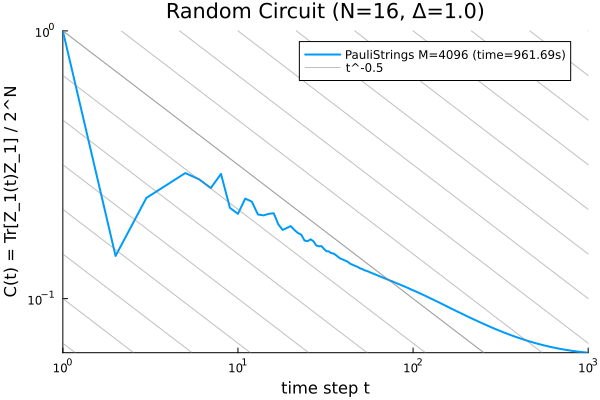

In [35]:
p = Plots.plot()

for M in Ms
    array_to_plot = [sum([results_pauli[M, trial][t][initial_site] for trial in 1:num_trials])/num_trials for t in 1:num_steps]
    plot!(1:num_steps, abs.(array_to_plot),
        label="PauliStrings M=$M (time=$(round(times_pauli[M],digits=2))s)", lw=2, yaxis=:log, xaxis=:log)
end



t=1:num_steps

limit_array = [results_pauli[2^12, 1][t][initial_site] for t in 1:num_steps]
power = round(-1/2, digits=3)
for offset in -100:100
    if offset == 0
        plot!(t, 10.0^(offset/6) .* float.(t) .^ power, color=:gray, alpha=0.5, lw=1, label="t^$power")
    end
    plot!(t, 10.0^(offset/6) .* float.(t) .^ power, color=:gray, alpha=0.5, lw=1, label="")
    continue
end
xlims!(1, maximum(t))
ylims!(minimum(abs.(limit_array)), maximum(abs.(limit_array)))

xlabel!("time step t")
ylabel!("C(t) = Tr[Z_$initial_site(t)Z_$initial_site] / 2^N")
title!("Random Circuit (N=$N, Δ=$Δ)")
plot!(grid=false)
plot!(legend=:topright)

In [11]:
using Distributions